In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
df_gemma = pd.read_csv('llm_mc1/gemma3_all.csv')
df_phi = pd.read_csv('llm_mc1/phi_all.csv')
df_qwen = pd.read_csv('llm_mc1/qwen2_all.csv')
df_dolphin = pd.read_csv('llm_mc1/tinydolphin_all.csv')
df_llama = pd.read_csv('llm_mc1/tinyllama_all.csv')

In [85]:
len(df_gemma)==len(df_phi)==len(df_qwen)==len(df_dolphin)==len(df_llama)

True

# Preprocessing

In [86]:
df = pd.read_json('dataset/mc_task.json')

In [87]:
def mc_dict_to_choices_labels(d: dict):
    """
    Input: {choice_text: 0/1, ...} with exactly one 1
    Output: choices(list[str]), labels(np.array[int]), gold_idx(int)
    """
    choices = list(d.keys())
    labels = np.array([int(v) for v in d.values()], dtype=int)

    # sanity checks
    if labels.sum() != 1:
        raise ValueError(f"Expected exactly one correct answer, got sum={labels.sum()}")

    gold_idx = int(labels.argmax())
    return choices, labels, gold_idx

In [88]:
always_A = True
bad_rows = []

for i, d in enumerate(df["mc1_targets"]):
    choices, labels, gold_idx = mc_dict_to_choices_labels(d)

    if gold_idx != 0:
        always_A = False
        bad_rows.append((i, gold_idx, choices[gold_idx]))

print("Correct answer always A?", always_A)
print("Number of violations:", len(bad_rows))

Correct answer always A? True
Number of violations: 0


In [89]:
import numpy as np

def shuffle_mc_question_from_dict(d, seed=42):
    """
    Input: mc1_targets dict {choice_text: 0/1}
    Output:
      - shuffled_choices (list[str])
      - correct_choice_text (str)
      - gold_idx (int, index in shuffled_choices)
    """
    choices, labels, _ = mc_dict_to_choices_labels(d)

    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(choices))

    shuffled_choices = [choices[i] for i in idx]
    shuffled_labels  = labels[idx]

    gold_idx = int(shuffled_labels.argmax())
    correct_choice_text = shuffled_choices[gold_idx]

    return shuffled_choices, correct_choice_text, gold_idx

In [90]:
df[["shuffled_choices", "correct_choice", "gold_idx"]] = df["mc1_targets"].apply(
    lambda d: pd.Series(shuffle_mc_question_from_dict(d)))

In [91]:
import string

dfs = [df_llama, df_dolphin, df_gemma, df_phi, df_qwen]

for d in dfs:
    d["pred_letter"] = d["pred_idx"].apply(
        lambda x: string.ascii_uppercase[int(x)] if pd.notnull(x) else None
    )

# Distributions

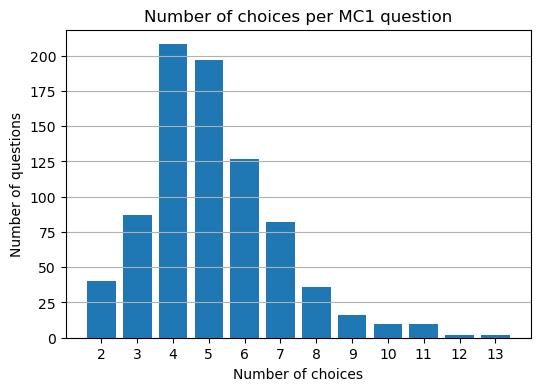

In [92]:
import matplotlib.pyplot as plt

# count number of choices per question
choice_lengths = df["shuffled_choices"].apply(lambda x: len(x) if isinstance(x, list) else 0)

# frequency table
counts = choice_lengths.value_counts().sort_index()

# bar plot
plt.figure(figsize=(6, 4))
plt.bar(counts.index, counts.values)
plt.xlabel("Number of choices")
plt.ylabel("Number of questions")
plt.title("Number of choices per MC1 question")
plt.xticks(counts.index)
plt.grid(axis="y")
plt.show()

In [93]:
def idx_to_letter(idx: int) -> str:
    return chr(ord("A") + idx)

df["gold_letter"] = df["gold_idx"].apply(idx_to_letter)

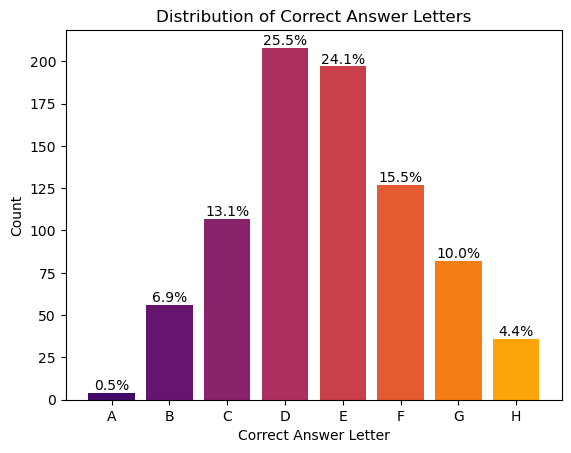

In [94]:
import matplotlib.pyplot as plt
import numpy as np

counts = df["gold_letter"].value_counts().sort_index()
total = counts.sum()
percentages = counts / total * 100

colors = plt.cm.inferno(np.linspace(0.2, 0.8, len(counts)))

plt.figure()
bars = plt.bar(counts.index, counts.values, color=colors)

plt.xlabel("Correct Answer Letter")
plt.ylabel("Count")
plt.title("Distribution of Correct Answer Letters")

# add percentage labels
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{pct:.1f}%",
        ha="center",
        va="bottom"
    )

plt.show()

In [95]:
random_guess=0
for i in range(len(df)):
    random_guess+=1/len(df.iloc[i]['shuffled_choices'])
random_guess/=len(df)

print(f"Random guess: {random_guess*100:.2f}%")

Random guess: 22.25%


# Helping functions

In [96]:
import matplotlib.pyplot as plt

def plot_correctness_pie(df, column="correct", title="Correct vs Incorrect Answers"):
    """
    Plots a pie chart of correct vs incorrect answers.

    Args:
        df (pd.DataFrame): DataFrame containing results
        column (str): Column with correctness labels (e.g. True/False or 0/1)
        title (str): Plot title
    """
    counts = df[column].value_counts().sort_index()

    labels = ["Incorrect", "Correct"]
    colors = ["#E74C3C", "#2ECC71"]  # red & green, high contrast

    plt.figure(figsize=(5, 5))
    plt.pie(
        counts.values,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=colors,
        wedgeprops={"edgecolor": "black", "linewidth": 1}
    )
    plt.title(title)
    plt.axis("equal")
    plt.show()

In [97]:
def plot_time_bar_with_avg(df, time_col="latency_s", bins=10, title="Response Time Distribution"):
    times = df[time_col].values

    # binning
    counts, bin_edges = np.histogram(times, bins=bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    avg_time = times.mean()
    median_time = np.median(times)

    total_hours = times.sum() / 3600

    plt.figure(figsize=(6, 4))
    plt.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]) * 0.9)

    # average line
    plt.axvline(
        avg_time,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Average = {avg_time:.2f} s"
    )

    plt.axvline(
        median_time,
        color="orange",
        linestyle="-.",
        linewidth=2,
        label=f"Median = {median_time:.2f} s"
    )

    plt.plot(
        [],
        [],
        " ",
        label=f"Total time = {total_hours:.2f} h"
    )

    plt.xlabel("Time (seconds)")
    plt.ylabel("Number of questions")
    plt.title(title)
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.show()

In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_binary_metrics(df, correct_col='correct'):
    """
    Computes binary classification metrics (accuracy)
    for a column indicating correct predictions (True/False or 1/0).

    Args:
        df (pd.DataFrame): DataFrame containing the results
        correct_col (str): Name of the column indicating correctness

    Returns:
        dict: Dictionary with metrics
    """
    correct = df[correct_col]

    # Compute metrics
    accuracy = accuracy_score(correct, [True]*len(correct))

    # Print nicely
    print(f"Accuracy: {accuracy:.2%}")

    return {'accuracy': accuracy}

In [99]:
def plot_letter_distribution(d, column='pred_letter', title="Distribution of Answer Letters"):
    counts = d[column].value_counts().sort_index()
    total = counts.sum()
    percentages = counts / total * 100

    colors = plt.cm.inferno(np.linspace(0.2, 0.8, len(counts)))

    plt.figure()
    bars = plt.bar(counts.index, counts.values, color=colors)

    plt.xlabel(column.replace("_", " ").title())
    plt.ylabel("Count")
    plt.title(title)

    # Add percentage labels
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{pct:.1f}%",
            ha="center",
            va="bottom"
        )

    plt.show()

# TinnyLlama

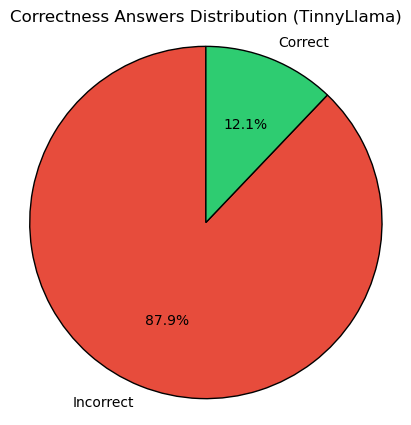

In [100]:
plot_correctness_pie(df_llama, title="Correctness Answers Distribution (TinnyLlama)")

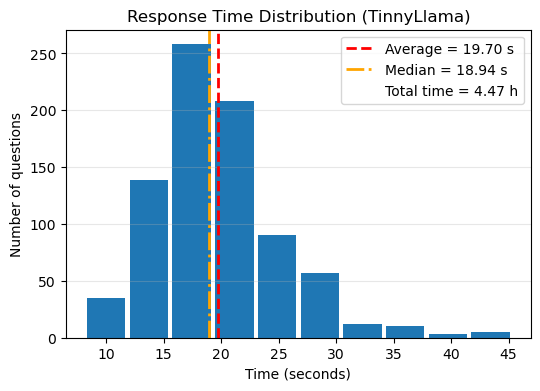

In [101]:
plot_time_bar_with_avg(df_llama, title="Response Time Distribution (TinnyLlama)")

In [102]:
metrics_llama = compute_binary_metrics(df_llama)

Accuracy: 12.12%


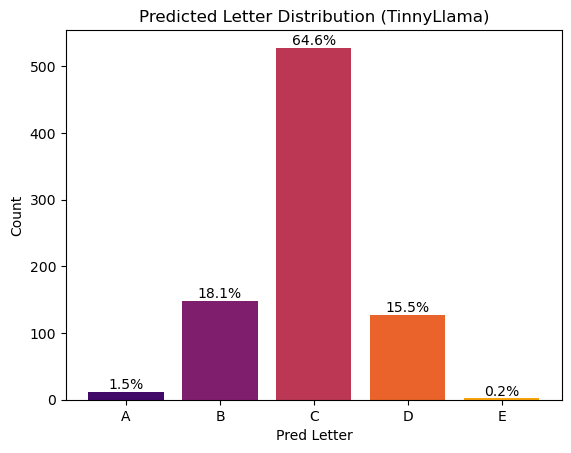

In [103]:
plot_letter_distribution(df_llama, title="Predicted Letter Distribution (TinnyLlama)")

In [104]:
df_llama["pred_idx"].value_counts(normalize=True)


pred_idx
2.0    0.646267
1.0    0.181151
3.0    0.155447
0.0    0.014688
4.0    0.002448
Name: proportion, dtype: float64

In [105]:
df_llama.groupby("correct")["latency_s"].mean()

correct
False    20.224540
True     15.921717
Name: latency_s, dtype: float64

# TinnyDoplhin

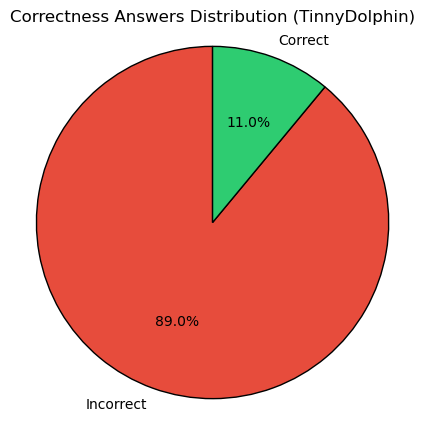

In [106]:
plot_correctness_pie(df_dolphin, title="Correctness Answers Distribution (TinnyDolphin)")

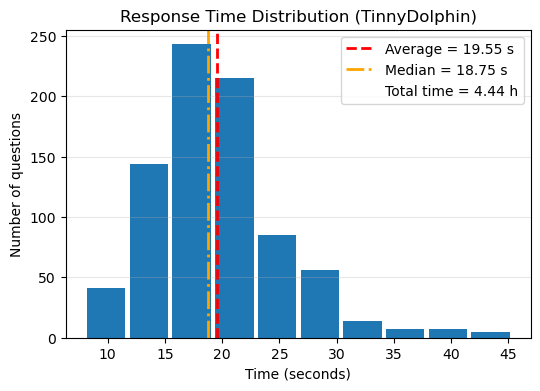

In [107]:
plot_time_bar_with_avg(df_dolphin, title="Response Time Distribution (TinnyDolphin)")

In [108]:
metrics_dolphin = compute_binary_metrics(df_dolphin)

Accuracy: 11.02%


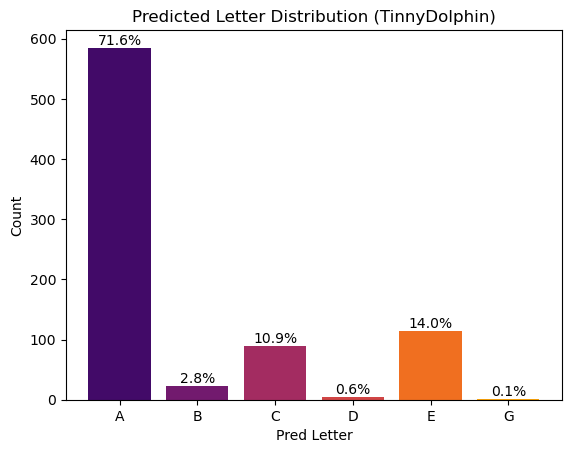

In [109]:
plot_letter_distribution(df_dolphin, title="Predicted Letter Distribution (TinnyDolphin)")

# Phi3.5

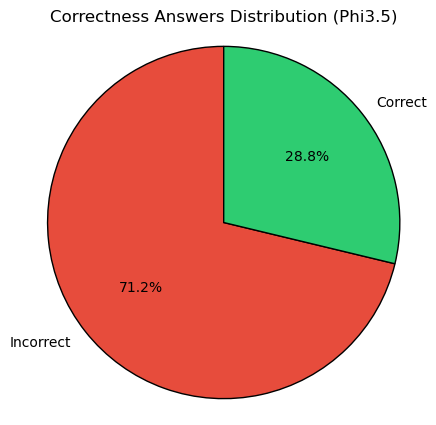

In [110]:
plot_correctness_pie(df_phi, title="Correctness Answers Distribution (Phi3.5)")

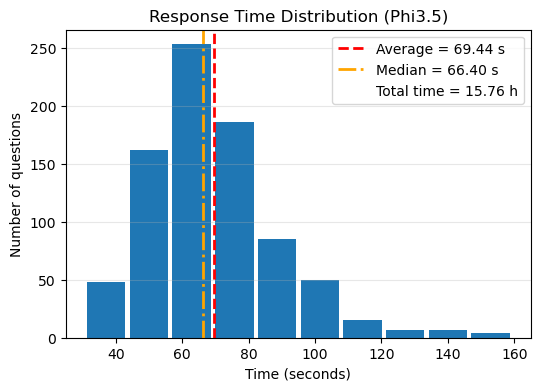

In [111]:
plot_time_bar_with_avg(df_phi, title="Response Time Distribution (Phi3.5)")

In [112]:
metrics_phi = compute_binary_metrics(df_phi)

Accuracy: 28.76%


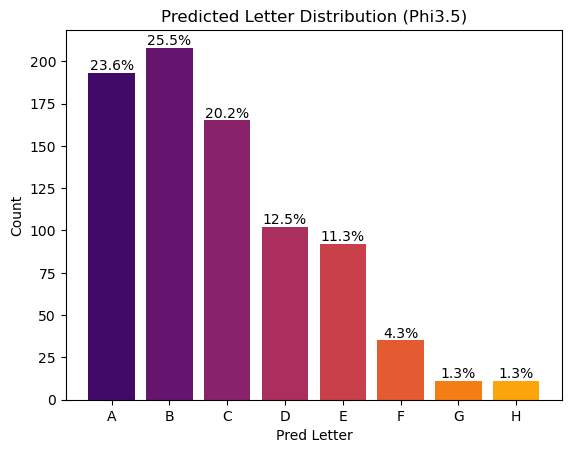

In [113]:
plot_letter_distribution(df_phi, title="Predicted Letter Distribution (Phi3.5)")

# Qwen2.5

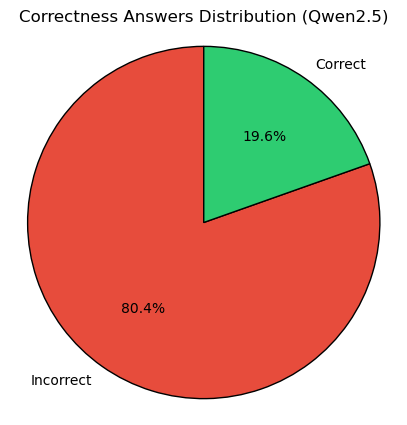

In [114]:
plot_correctness_pie(df_qwen, title="Correctness Answers Distribution (Qwen2.5)")

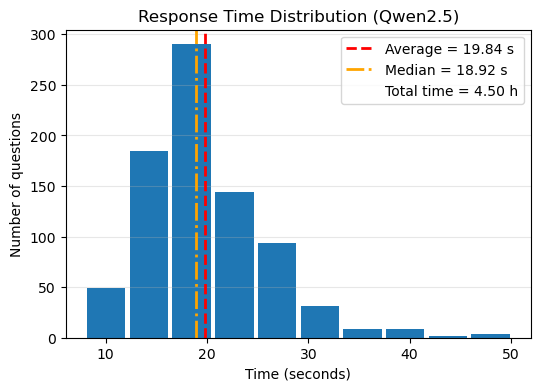

In [115]:
plot_time_bar_with_avg(df_qwen, title="Response Time Distribution (Qwen2.5)")

In [116]:
metrics_qwen = compute_binary_metrics(df_qwen)

Accuracy: 19.58%


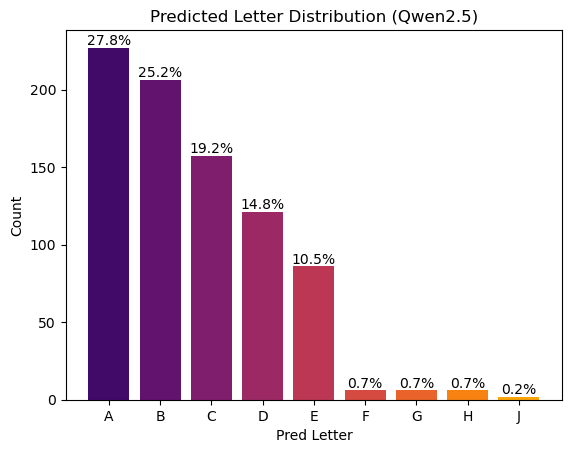

In [117]:
plot_letter_distribution(df_qwen, title="Predicted Letter Distribution (Qwen2.5)")

# Gemma3

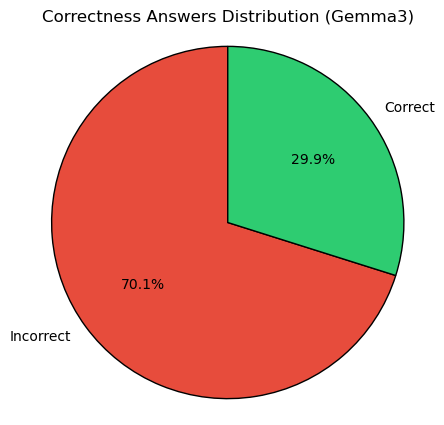

In [118]:
plot_correctness_pie(df_gemma, title="Correctness Answers Distribution (Gemma3)")

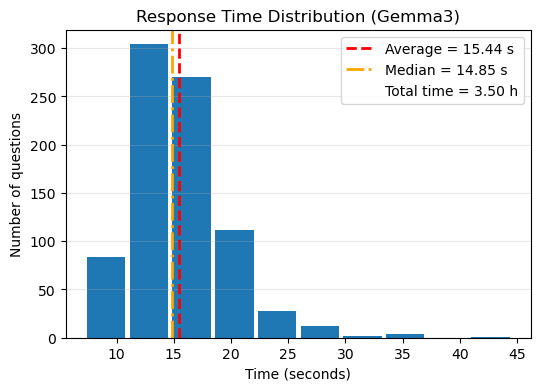

In [119]:
plot_time_bar_with_avg(df_gemma, title="Response Time Distribution (Gemma3)")

In [120]:
metrics_gemma = compute_binary_metrics(df_gemma)

Accuracy: 29.87%


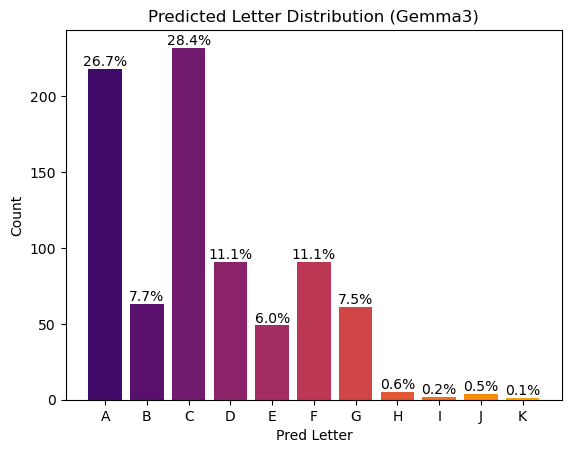

In [121]:
plot_letter_distribution(df_gemma, title="Predicted Letter Distribution (Gemma3)")

# Comparison

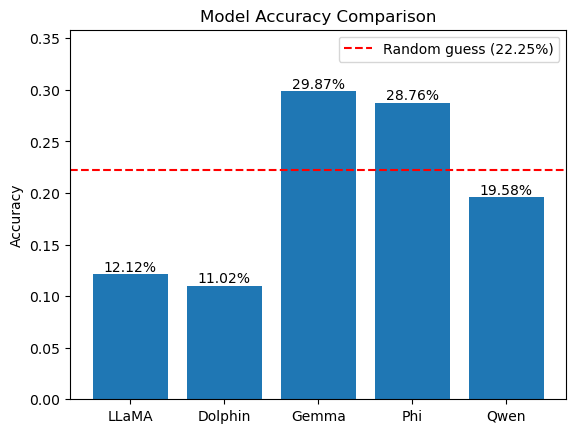

In [122]:
models = {
    "LLaMA": df_llama,
    "Dolphin": df_dolphin,
    "Gemma": df_gemma,
    "Phi": df_phi,
    "Qwen":df_qwen
}

accuracies = {name: df["correct"].mean() for name, df in models.items()}

plt.figure()
plt.bar(accuracies.keys(), accuracies.values())

plt.axhline(random_guess, color = 'red', linestyle="--", label=f"Random guess ({random_guess:.2%})")

plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

for i, v in enumerate(accuracies.values()):
    plt.text(i, v, f"{v:.2%}", ha="center", va="bottom")

plt.ylim(0, max(accuracies.values()) * 1.2)
plt.legend()
plt.show()

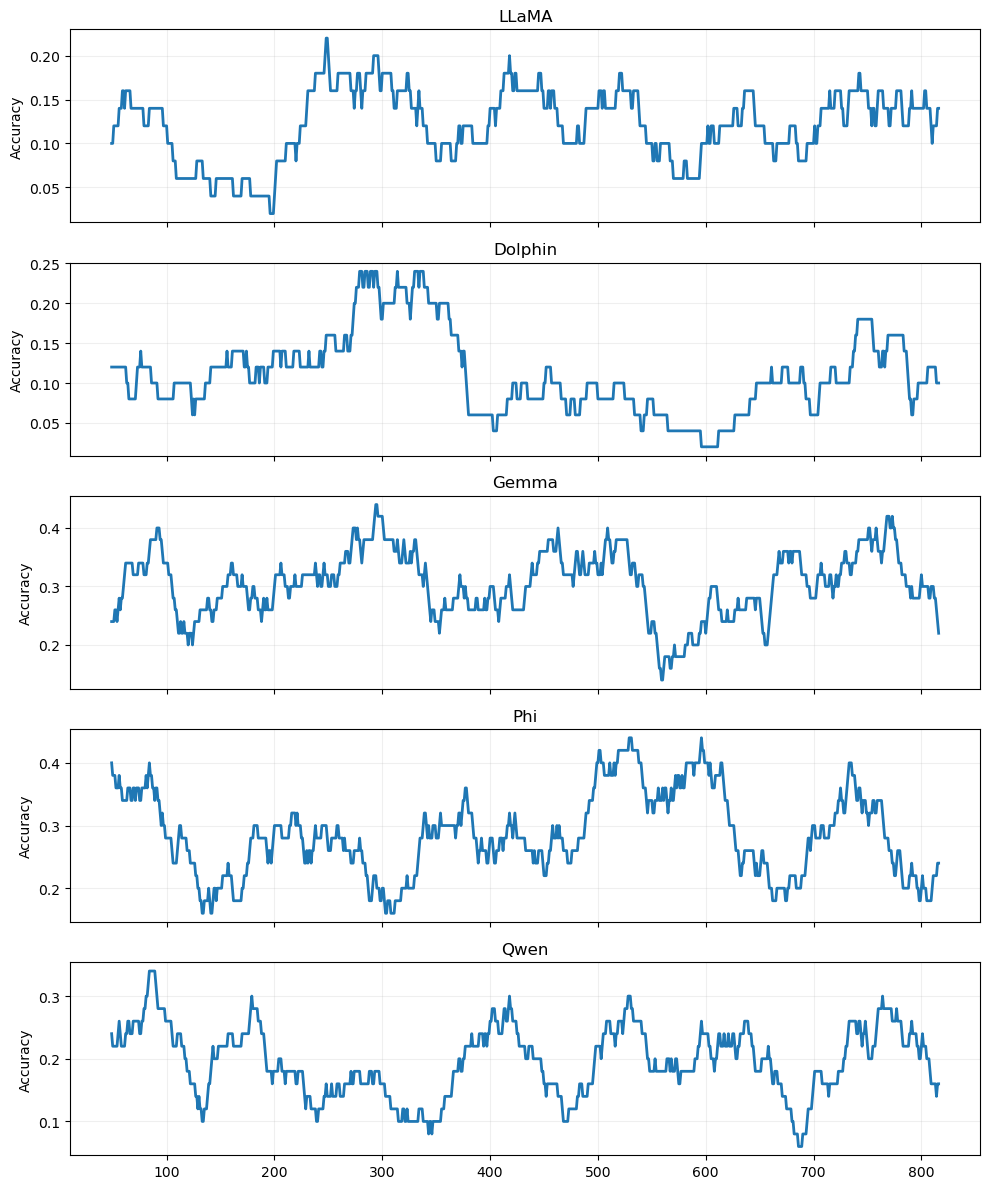

In [123]:
fig, axes = plt.subplots(len(models), 1, figsize=(10,12), sharex=True)

for ax, (name, df) in zip(axes, models.items()):
    roll = df["correct"].rolling(50).mean()
    ax.plot(roll, linewidth=2)
    ax.set_title(name)
    ax.set_ylabel("Accuracy")
    ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()


In [42]:
null_rows = df_gemma[df_gemma['pred_idx'].isna()]

# Show them
print(null_rows)

Empty DataFrame
Columns: [Unnamed: 0, question_num, raw_response, pred_letter, pred_idx, correct, gold_idx, valid, latency_s]
Index: []


In [43]:
null_rows = df_phi[df_phi['pred_idx'].isna()]

# Show them
print(null_rows)

Empty DataFrame
Columns: [Unnamed: 0, question_num, raw_response, pred_letter, pred_idx, correct, gold_idx, valid, latency_s]
Index: []


In [79]:
null_rows = df_qwen[df_qwen['pred_idx'].isna()]

# Show them
print(null_rows)

Empty DataFrame
Columns: [Unnamed: 0, question_num, raw_response, pred_letter, pred_idx, correct, gold_idx, valid, latency_s]
Index: []
